In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time
import spacy
import torchtext
from torchtext import data, datasets

font = {'size'   : 20}

matplotlib.rc('font', **font)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SEED = 947
torch_utils.seed_everything(SEED)

In [3]:
spacy_de = spacy.load("de")
spacy_en = spacy.load("en")

In [4]:
def tokenize_de(txt):
    return [tok.text for tok in spacy_de.tokenizer(txt)]
def tokenize_en(txt):
    return [tok.text for tok in spacy_en.tokenizer(txt)]

In [5]:
SRC = data.Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, include_lengths=True)
TRG = data.Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True)

In [6]:
train_data, valid_data, test_data = datasets.Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

In [7]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2, vectors="glove.6B.300d", unk_init=torch.Tensor.normal_)

100%|█████████▉| 399912/400000 [00:42<00:00, 9407.29it/s] 

In [8]:
BATCH_SIZE = 164

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x : len(x.src),
    device=device
)

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(2*enc_hid_dim, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, txt, txt_len):
        # txt -- len(src) X batch_size
        # txt_len -- batch_size
        embedded = self.dropout(self.embedding(txt))
        # embedded -- len(src) X batch_size X emb_dim
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, txt_len)
        #packed_embedded -- embedded
        
        packed_outputs, hidden = self.rnn(packed_embedded)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        return outputs, hidden

In [10]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear((enc_hid_dim*2)+dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
    
    def forward(self, hidden, encoder_outputs, mask):
        # hidden -- batch_size X dec_hid_dim
        # encoder_outputs -- len(src) X batch_size X enc_hid_dim*2
        # mask -- batch_size X len(src)
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(dim=1).repeat(1,src_len,1)
        # hidden -- batch_size X len(src) X dec_hid_dim
        encoder_outputs = encoder_outputs.permute(1,0,2)
        # encoder_outputs -- batch_size X len(src) X enc_hid_dim*2
        
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy -- batch_size X len(src) X dec_hid_dim
        v = self.v.repeat(batch_size, 1)
        # v -- batch_size X dec_hid_dim
        v = v.unsqueeze(dim=1)
        # v -- batch_size X 1 X dec_hid_dim
        energy = energy.permute(0, 2, 1)
        # energy -- batch_size X dec_hid_dim X len(src)
        
        attention = torch.bmm(v, energy).squeeze(dim=1)
        # attention -- batch_size X len(src)
        
        attention = attention.masked_fill(mask==0, -1e10)
        
        return F.softmax(attention, dim=1)

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim*2)+emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim*2)+emb_dim+dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, hidden, encoder_outputs, mask):
        # trg -- batch_size
        # hidden -- batch_size X dec_hid_dim
        # encoder_outputs -- len(src) X batch_size X 2*enc_hid_dim
        # mask -- batch_size X len(src)
        
        trg = trg.unsqueeze(dim=0)
        embedded = self.dropout(self.embedding(trg))
        # embedded -- 1 X batch_size X emb_dim
        a = self.attention(hidden, encoder_outputs, mask)
        # a -- batch_size X len(src)
        a = a.unsqueeze(dim=1)
        # a -- batch_size X 1 X len(src)
        encoder_outputs = encoder_outputs.permute(1,0,2)
        # encoder_outputs -- batch_size X len(src) X 2*enc_hid_dim
        weighted_enc_outs = torch.bmm(a, encoder_outputs)
        # weighted_enc_outs -- batch_size X 1 X 2*enc_hid_dim
        weighted_enc_outs = weighted_enc_outs.permute(1,0,2)
        # weighted_enc_outs -- 1 X batch_size X 2*enc_hid_dim
        
        embedded_weighted_enc_outs = torch.cat((embedded, weighted_enc_outs), dim=2)
        # embedded_weighted_enc_outs -- 1 X batch_size X 2*enc_hid_dim + emb_dim
        output, hidden = self.rnn(embedded_weighted_enc_outs, hidden.unsqueeze(dim=0))
        # output -- 1 X batch_size X dec_hid_dim
        # hidden -- (dir*layer=1) X batch_size X dec_hid_dim
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(dim=0)
        weighted_enc_outs = weighted_enc_outs.squeeze(dim=0)
        output = output.squeeze(dim=0)
        
        prediction = self.fc_out(torch.cat((output, weighted_enc_outs, embedded), dim=1))
        return prediction, hidden.squeeze(dim=0), a.squeeze(dim=1)

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
    
    def create_mask(self, src):
        mask = (src!=self.src_pad_idx).permute(1, 0)
        return mask
    
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # src -- len(src) X batch_size
        # src_len -- batch_size
        # trg -- len(trg) X batch_size
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_outputs, ht = self.encoder(src, src_len)
        
        current_input_tokens = trg[0, :]
        # current_input_tokens --  1 X batch_size
        
        mask = self.create_mask(src)
        # mask -- batch_size X len(src)
        
        for t in range(1, trg_len):
            ot, ht, at = self.decoder(current_input_tokens, ht, encoder_outputs, mask)
            outputs[t] = ot
            teacher_force = random.random()<teacher_forcing_ratio
            top1 = ot.argmax(1)
            current_input_tokens = trg[t] if teacher_force else top1
        
        return outputs

In [13]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [14]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    torch_utils.clear_cuda()
    l=0
    
    for batch in tqdm(iterator):
        trg = batch.trg
        src, src_len = batch.src
        
        optimizer.zero_grad()
        
        outputs = model(src, src_len, trg)
        output_dim = outputs.shape[-1]
        outputs = outputs[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(outputs, trg)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        l+=loss.item()
    return l/len(iterator)

In [15]:
def evaluate(model, iterator, criterion):
    model.eval()
    l=0
    with torch.no_grad():
        for batch in tqdm(iterator):
            trg = batch.trg
            src, src_len = batch.src
            outputs = model(src, src_len, trg, 0)
            output_dim = outputs.shape[-1]
            outputs = outputs[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(outputs, trg)
            l+=loss.item()
    return l/len(iterator)

In [16]:
pretrained_embeddings = TRG.vocab.vectors
pretrained_embeddings.shape

torch.Size([5893, 300])

In [51]:
INP_DIM = len(SRC.vocab)
OUT_DIM = len(TRG.vocab)
ENC_EMB = 300
DEC_EMB = 300
ENC_HID = 512
DEC_HID = 512
ENC_DRP = 0.5
DEC_DRP = 0.5
PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
UNK_IDX = SRC.vocab.stoi[SRC.unk_token]

torch_utils.clear_cuda()
attn = Attention(ENC_HID, DEC_HID)
encd = Encoder(INP_DIM, ENC_EMB, ENC_HID, DEC_HID, ENC_DRP)

decd = Decoder(OUT_DIM, DEC_EMB, ENC_HID, DEC_HID, DEC_DRP, attn)
# decd.embedding.weight.data.copy_(pretrained_embeddings)
# decd.embedding.weight.data[UNK_IDX] = torch.zeros(DEC_EMB)
# decd.embedding.weight.data[PAD_IDX] = torch.zeros(DEC_EMB)

model = Seq2Seq(encd, decd, PAD_IDX, device).to(device)
model = model.apply(init_weights)

In [52]:
torch_utils.count_model_params(model)

21585873

In [53]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
optimizer = optim.Adam(model.parameters())
N_EPOCHS = 30
CLIP = 1
checkpt_path = "PPM_BEST_MODEL.pt"
history = pd.DataFrame()
ea = torch_utils.EarlyStopping(patience=3, verbose=True, save_model_name=checkpt_path)
TRAIN = True

In [54]:
if TRAIN:
    for e in range(N_EPOCHS):
        st = time.time()
        tl = train(model, train_iterator, optimizer, criterion, CLIP)
        vl = evaluate(model, valid_iterator, criterion)
        TPL = np.exp(tl)
        VPL = np.exp(vl)
        ea(VPL, model)
        torch_utils.print_epoch_stat(e, time.time()-st, history=history, train_loss=tl, valid_loss=vl)
        print("\t\tTPL \t\t{:0.5}".format(TPL))
        print("\t\tVPL \t\t{:0.5}".format(VPL))
        history.loc[e, "TPL"] = TPL
        history.loc[e, "VPL"] = VPL
        torch_utils.clear_cuda()

        if ea.early_stop:
            break


Found better solution (inf --> 136.354317).  Saving model ...


EPOCH 1 Completed, Time Taken: 0:00:36.488981
	Train Loss 	5.09361003
	Valid Loss 	4.91525677
		TPL 		162.98
		VPL 		136.35



Found better solution (136.354317 --> 98.757213).  Saving model ...


EPOCH 2 Completed, Time Taken: 0:00:36.247598
	Train Loss 	4.28209592
	Valid Loss 	4.59266445
		TPL 		72.392
		VPL 		98.757



Found better solution (98.757213 --> 50.533396).  Saving model ...


EPOCH 3 Completed, Time Taken: 0:00:36.228536
	Train Loss 	3.62562825
	Valid Loss 	3.92263443
		TPL 		37.548
		VPL 		50.533



Found better solution (50.533396 --> 39.193842).  Saving model ...


EPOCH 4 Completed, Time Taken: 0:00:35.807297
	Train Loss 	3.07659659
	Valid Loss 	3.66851963
		TPL 		21.684
		VPL 		39.194



Found better solution (39.193842 --> 31.196143).  Saving model ...


EPOCH 5 Completed, Time Taken: 0:00:36.495778
	Train Loss 	2.66796457
	Valid Loss 	3.44029447
		TPL 		14.411
		VPL 		31.196



EarlyStopping counter: 1 out of 3


EPOCH 6 Completed, Time Taken: 0:00:35.311273
	Train Loss 	2.3541704
	Valid Loss 	3.45170338
		TPL 		10.529
		VPL 		31.554



Found better solution (31.196143 --> 30.163876).  Saving model ...


EPOCH 7 Completed, Time Taken: 0:00:36.368824
	Train Loss 	2.07991116
	Valid Loss 	3.40664506
		TPL 		8.0038
		VPL 		30.164



Found better solution (30.163876 --> 28.711736).  Saving model ...


EPOCH 8 Completed, Time Taken: 0:00:36.798008
	Train Loss 	1.90125006
	Valid Loss 	3.35730597
		TPL 		6.6943
		VPL 		28.712



Found better solution (28.711736 --> 28.331592).  Saving model ...


EPOCH 9 Completed, Time Taken: 0:00:36.376248
	Train Loss 	1.69731261
	Valid Loss 	3.34397752
		TPL 		5.4593
		VPL 		28.332



EarlyStopping counter: 1 out of 3


EPOCH 10 Completed, Time Taken: 0:00:35.176609
	Train Loss 	1.55435946
	Valid Loss 	3.43675297
		TPL 		4.7321
		VPL 		31.086



EarlyStopping counter: 2 out of 3


EPOCH 11 Completed, Time Taken: 0:00:35.194182
	Train Loss 	1.44498205
	Valid Loss 	3.49581163
		TPL 		4.2418
		VPL 		32.977



EarlyStopping counter: 3 out of 3


EPOCH 12 Completed, Time Taken: 0:00:35.430692
	Train Loss 	1.34116336
	Valid Loss 	3.46823015
		TPL 		3.8235
		VPL 		32.08


In [63]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load("de")
        tokens = [token.text.lower() for token in nlp.tokensize(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    
    tokens = [src_field.init_token]+tokens+[src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    # add a batch dimension now
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(dim=1).to(device)
    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
    
    mask = model.create_mask(src_tensor)
    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [64]:
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(15,15))
    ax  = fig.add_subplot(111)
    
    attention = attention.squeeze(dim=1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap="bone")
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([""]+["<sos>"]+[t.lower() for t in sentence]+["<eos>"], rotation=45)
    ax.set_yticklabels([""]+translation)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    
    plt.show()
    plt.close()

In [65]:
example_idx = 0
src = vars(test_data.examples[example_idx])["src"]
trg = vars(test_data.examples[example_idx])["trg"]

print(f"src = {src}")
print(f"trg = {trg}")

src = ['ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', 'anstarrt', '.']
trg = ['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.']


['a', 'man', 'wearing', 'an', 'orange', 'hat', 'is', 'something', '.', '<eos>']


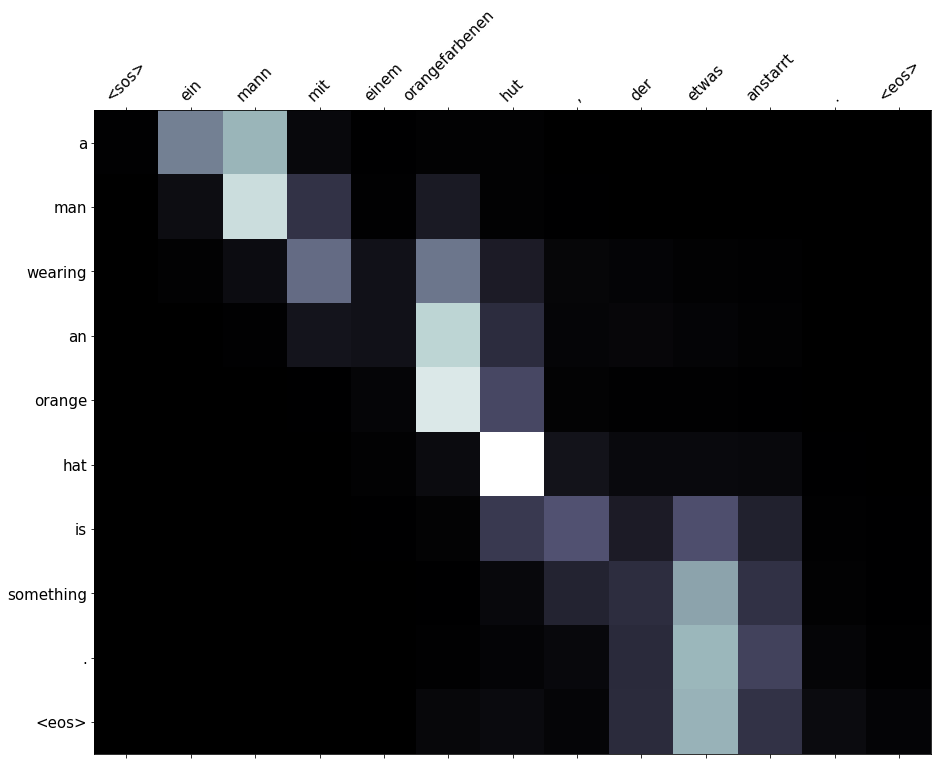

In [66]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(translation)
display_attention(src, translation, attention)

In [67]:
ls = evaluate(model, test_iterator, criterion)
print("OF -- LOSS {:0.5} PL {:0.5}".format(ls, np.exp(ls)))


OF -- LOSS 3.4048 PL 30.109


In [68]:
model.load_state_dict(torch.load(checkpt_path, map_location=device))

<All keys matched successfully>

['a', 'man', 'wearing', 'an', 'orange', 'hat', 'is', 'something', '.', '<eos>']


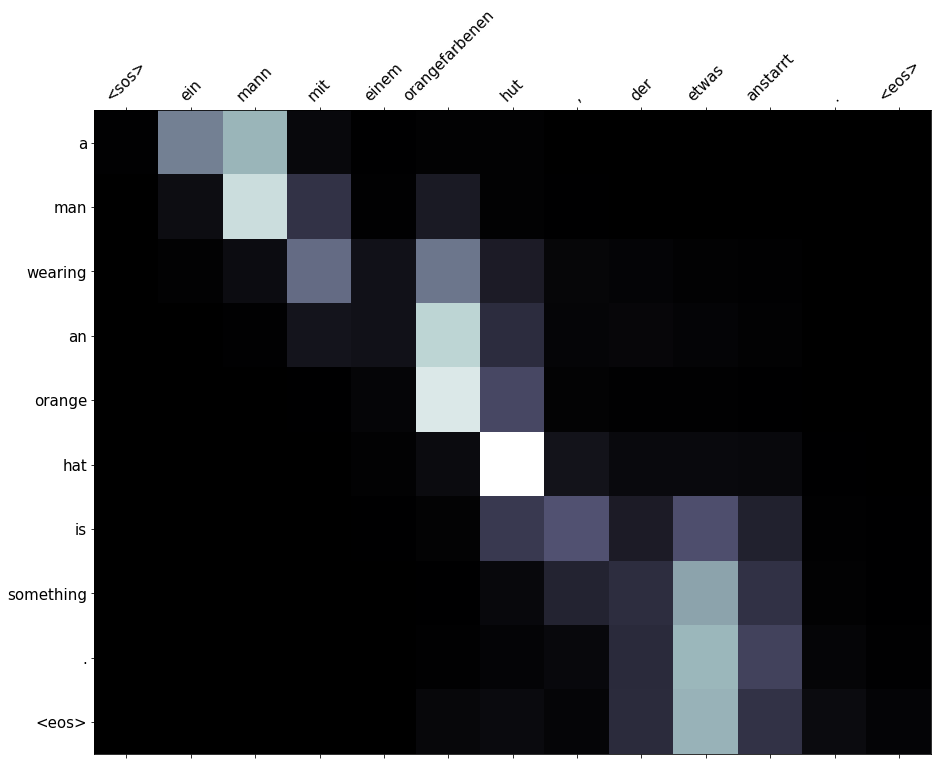

In [69]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(translation)
display_attention(src, translation, attention)

In [70]:
ls = evaluate(model, test_iterator, criterion)
print("Best -- LOSS {:0.5} PL {:0.5}".format(ls, np.exp(ls)))


Best -- LOSS 3.4048 PL 30.109


In [75]:
import bleu

def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    
    for dataum in tqdm(data):
        src = vars(dataum)["src"]
        trg = vars(dataum)["trg"]
        
        pred_trg,_ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        pred_trg = pred_trg[:-1]
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu.bleu_score(pred_trgs, trgs)

In [76]:
bleu = calculate_bleu(test_data, SRC, TRG, model, device)

print(f"BLEU = {100.0*bleu}")


BLEU = 30.52551067108144
